# Import libraries

In [1]:
import os
from pathlib import Path
import pandas
%load_ext autoreload
%autoreload 2

# Specify a image folder

In [2]:
IMAGE_FOLDER = Path(os.getcwd()).parent.parent.parent/'Data'/'houses/resize128jpg/train'

#test
assert os.path.isdir(IMAGE_FOLDER), str(str(IMAGE_FOLDER) + " is not an existing directory.")

# Specify columns

In [3]:
UNLABELED_TAG = "UNLABELED"

ATTRIBUTES = {
    "house_color":["WhiteGreyHouse","BrownHouse","BrickHouse","RedPinkOrangeHouse","BlueHouse","MixedHouse"],
    "fence_type":["WhitePicketFence","BlackFence","NoFence","ChainFence","BrownFence"],
    "steps_up":["NoSteps","Steps","LargePorch"]
}
for key in ATTRIBUTES.keys():
    ATTRIBUTES[key].append(UNLABELED_TAG)

# Specify a CSV (existing or not) and Image Column

In [4]:
OVERWRITE_CSV = False
CSV_PATH = Path('metadata_resized.csv').absolute()
CSV_IMAGE_COLUMN = 'image_path' #relative path of image inside IMG_FOLDER e.g. train/cat/10.jpg

#test
assert(os.path.isdir(CSV_PATH.parent))
if (not os.path.isfile(CSV_PATH)) or OVERWRITE_CSV:
    print("OVERWRITING CSV ")
    from lib.prep import create_csv_with_image_paths
    output = create_csv_with_image_paths(CSV_PATH, CSV_IMAGE_COLUMN, IMAGE_FOLDER, list(ATTRIBUTES.keys()))

# Load Widget
Widget loads subset (4 or so) images for user to label

In [5]:
from lib.widgets import MultilabelerWidget
        
mlw = MultilabelerWidget(csv_path = CSV_PATH, image_folder = IMAGE_FOLDER, image_column=CSV_IMAGE_COLUMN, attributes=ATTRIBUTES, width = 300)

# Load labeled images into dataset

In [6]:
df = pandas.read_csv(CSV_PATH)

In [79]:

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage import io, transform
from PIL import Image

class OneHotEncoder:
    def __init__(self, attributes):
        self.set_sizes = []
        for option_set in attributes.values():
            self.set_sizes.append(len(option_set)-1)
        
    def encode(self, tensor):
        encoded = []
        for idx, code in enumerate(tensor[0]):
            encoded+=([i==code for i in range(self.set_sizes[idx])])
        return encoded
        
    
class ValueToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, value):
        value = torch.from_numpy(value).float()
        return value
    
class HouseDataset(Dataset):

    def __init__(self, df, attributes, image_path_column, image_folder, image_height=128, image_width=128):
        self.df = df
        self.attributes = attributes
        self.image_path_column = image_path_column
        self.image_folder = image_folder
        self.one_hot_encoder = OneHotEncoder(self.attributes)
        self.image_transforms=transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size = (image_height,image_width), interpolation=Image.NEAREST),
            transforms.ToTensor(),
        ])
        self.value_transforms = transforms.Compose([
            ValueToTensor()
        ])
    
    def __len__(self):
        return len(df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_folder,
                                self.df.iloc[idx][self.image_path_column])
        if False: #TODO image_path_field ends in 64\
            pass
        else:
            image = io.imread(img_name)
            image = self.image_transforms(image)
        vals = self.df.iloc[idx][list(self.attributes)].astype('category').cat.codes.astype('float')
        vals = np.array([vals])
        vals = self.value_transforms(vals)
        vals = self.one_hot_encoder.encode(vals)
        sample = {'image': image, 'vals': vals}


        return (image, vals)
    
house_dataset= HouseDataset(df = df,
                            attributes = ATTRIBUTES, 
                            image_path_column = CSV_IMAGE_COLUMN,
                            image_folder = IMAGE_FOLDER
                           )

In [80]:
house_dataset[0][1]

[tensor(False),
 tensor(False),
 tensor(True),
 tensor(False),
 tensor(False),
 tensor(False),
 tensor(True),
 tensor(False),
 tensor(False),
 tensor(False),
 tensor(False),
 tensor(False),
 tensor(True),
 tensor(False)]

In [74]:
torch.stack(encoded).shape


torch.Size([14])

In [55]:
ohe.set_sizes

[6, 5, 3]

In [21]:
attribute = 'house_color'
labeled_house_colors = df[df[attribute]!=UNLABELED_TAG]

In [8]:
labeled_house_colors

,id,id.1,id.1.1,id.1.1.1,id.1.1.1.1,id.1.1.1.1.1,image_path,house_color,fence_type,steps_up
0,0,0,0,0,0,0,0.jpg,WhiteGreyHouse,NoFence,NoSteps
1,1,1,1,1,1,1,1.jpg,WhiteGreyHouse,NoFence,LargePorch
2,2,2,2,2,2,2,10.jpg,WhiteGreyHouse,BrownFence,NoSteps
3,3,3,3,3,3,3,100.jpg,RedPinkOrangeHouse,NoFence,NoSteps
4,4,4,4,4,4,4,1000.jpg,WhiteGreyHouse,NoFence,NoSteps
5,5,5,5,5,5,5,10000.jpg,BrickHouse,NoFence,NoSteps
6,6,6,6,6,6,6,10001.jpg,BrownHouse,NoFence,NoSteps
7,7,7,7,7,7,7,10002.jpg,BrownHouse,NoFence,NoSteps
8,8,8,8,8,8,8,10003.jpg,MixedHouse,NoFence,UNLABELED
9,9,9,9,9,9,9,10004.jpg,BrickHouse,NoFence,UNLABELED


In [9]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.vision.data import *

In [11]:
path = Path(os.getcwd()).parent.parent.parent
folder = IMAGE_FOLDER.relative_to(path)


data = ImageDataBunch.from_df(bs = 4,
                              path = path,
                              df = df, 
                              folder = folder, 
                              fn_col = CSV_IMAGE_COLUMN, 
                              one_hot=False,
                              label_col=list(ATTRIBUTES))

TypeError: create_from_ll() got an unexpected keyword argument 'one_hot'

In [51]:
data

ValueError: could not convert string to float: 'WhiteGreyHouse'

# Specify a save location for the classifier model

In [27]:
CLASSIFIER_EXPORT = Path(os.getcwd())/'classifier_export.pt'

In [28]:
data.c

4

In [44]:
learn = None

In [45]:
if learn is None:
  learn = cnn_learner(data, models.resnet18, metrics=error_rate, pretrained=True, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,error_rate,time
0,1.487653,3.225311,1.000000,00:00
1,1.418355,3.148820,1.000000,00:00
2,1.383443,3.129136,1.000000,00:00
3,1.369199,2.492251,1.000000,00:00


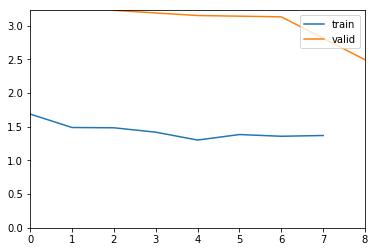

In [46]:
learn.fit_one_cycle(4)

In [32]:
from lib.widgets import MultilabelerActiveLearningWidget

In [49]:
from lib.widgets import MultilabelerActiveLearningWidget
        
mlw = MultilabelerActiveLearningWidget(learner = learn, classifier_export= CLASSIFIER_EXPORT, 
                         csv_path = CSV_PATH,
                         image_folder = IMAGE_FOLDER, 
                         image_column=CSV_IMAGE_COLUMN, 
                         attributes=ATTRIBUTES,
                                       unlabeled_tag = UNLABELED_TAG,
                         width = 300)

# Train VAE

# Load classifier / train new classifier

# Load classifier + vae + modification vector for each column